# OpenCV Face Detection HDMI

In this notebook, opencv face detection will be applied to HDMI input images.

To run all cells in this notebook a HDMI input source and HDMI output monitor are required.  

References:

https://github.com/Itseez/opencv/blob/master/data/haarcascades/haarcascade_frontalface_default.xml
https://github.com/Itseez/opencv/blob/master/data/haarcascades/haarcascade_eye.xml

### Step 1: Load the overlay

In [1]:
from pynq.overlays.base import BaseOverlay
from pynq.lib.video import *

base = BaseOverlay("base.bit")
hdmi_in = base.video.hdmi_in
hdmi_out = base.video.hdmi_out

### Step 2: Initialize HDMI I/O

In [2]:
hdmi_in.configure(PIXEL_RGB)
hdmi_out.configure(hdmi_in.mode, PIXEL_RGB)

hdmi_in.start()
hdmi_out.start()

### Step 3: Show input frame using IPython Image
Source: http://gardnerproductions.ca/wp-content/uploads/2015/11/bigstock-People-with-different-emotions-930x701-thegem-blog-default.jpg

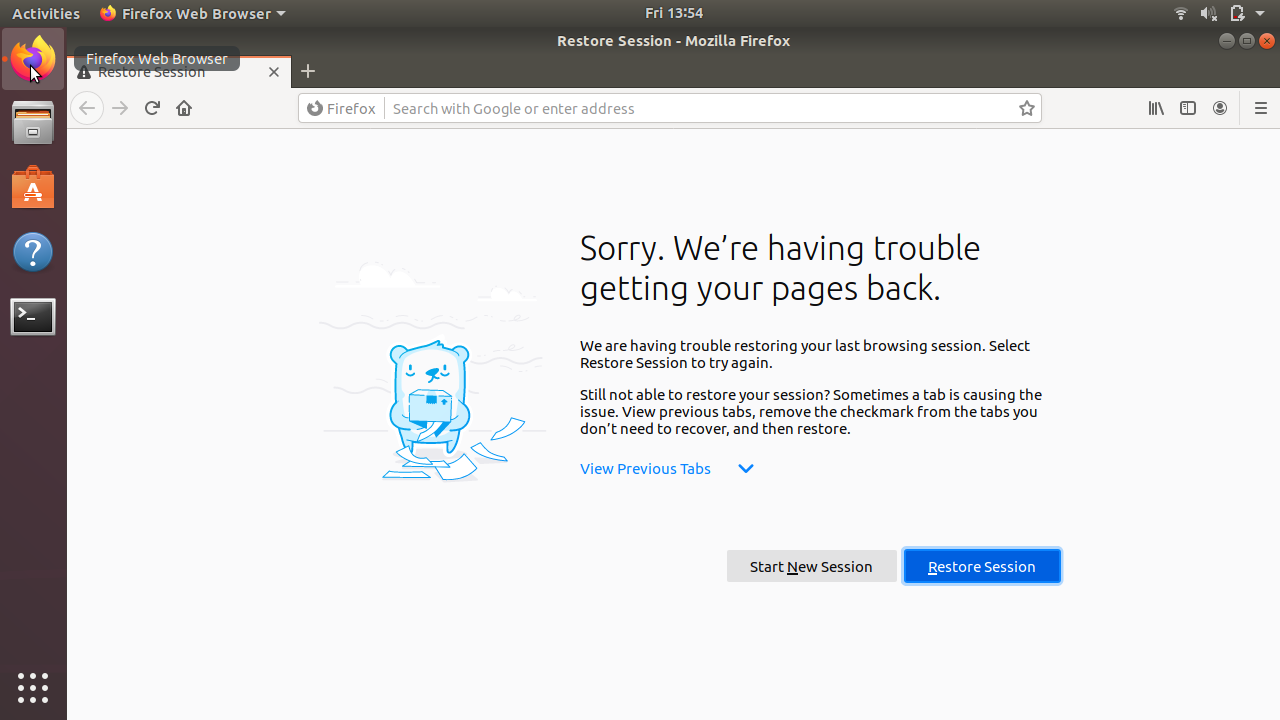

In [3]:
import PIL.Image
frame = hdmi_in.readframe()
img = PIL.Image.fromarray(frame)
img.save("/home/xilinx/jupyter_notebooks/base/video/data/face_detect.jpg")

img

### Step 4: Apply the face detection to the input

In [74]:
import cv2
import numpy as np
import PIL.Image
import time

numframes = 120
_all = True

face_cascade = cv2.CascadeClassifier(
    '/home/xilinx/jupyter_notebooks/base/video/data/'
    'haarcascade_frontalface_default.xml')


def scan(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    return face_cascade.detectMultiScale(gray, 1.3, 5)


faces = ()
for framenum in range(numframes):
    t_start = time.time()
    frame = hdmi_in.readframe()
    if not framenum % 60:
        faces = scan(frame)
    size_inc_default = 50
    for face in faces:
        face.append(size_inc_default)
    for facenum, (x, y, w, h, size_inc) in enumerate(faces):

        small_frame = frame[y - size_inc:y + h + size_inc, x - size_inc:x + w + size_inc]
        small_faces = scan(small_frame)
        #         img = PIL.Image.fromarray(small_frame)
        cv2.rectangle(frame, (x - size_inc, y - size_inc), (x + w + size_inc, y + h + size_inc), (255, 255, 0), 2)

        if len(small_faces) > 1:
            print("Warning, multiple small faces")
        elif len(small_faces) == 0:
            cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 255), 2)
            faces[facenum] = (x, y, w, h, size_inc+10)
        for (xs, ys, ws, hs) in small_faces:
            faces[facenum] = (x + xs - size_inc, y + ys - size_inc, ws, hs, size_inc)
            cv2.rectangle(frame, (x + xs - size_inc, y + ys - size_inc),
                          (x + xs + ws - size_inc, y + ys + hs - size_inc), (255, 0, 0), 2)
            break

    #     print(f"dt: {time.time()-t_start}; #faces: {len(faces)}")
    hdmi_out.writeframe(frame)

### Step 5: Show results on HDMI output
Output OpenCV results via HDMI.

In [7]:
hdmi_out.writeframe(frame)

### Step 6: Show results within notebook
Output OpenCV results as JPEG.

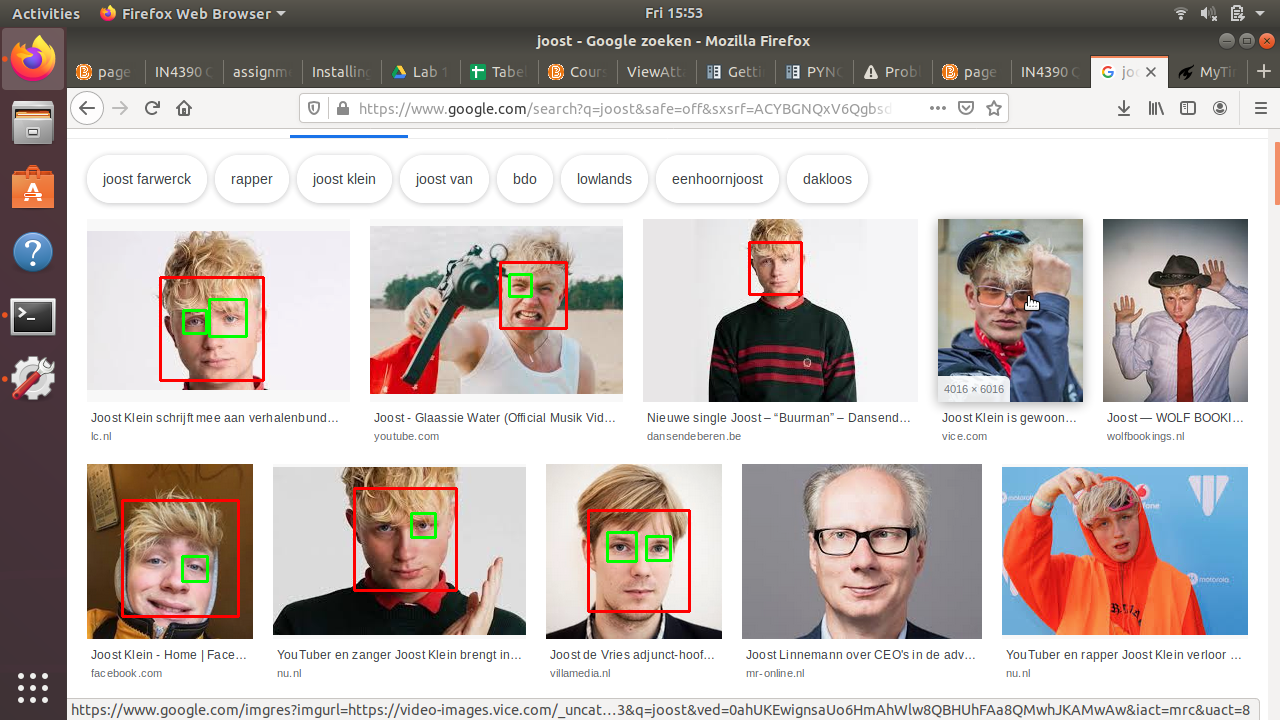

In [6]:
img = PIL.Image.fromarray(frame)
img.save("/home/xilinx/jupyter_notebooks/base/video/data/face_detect.jpg")

img

### Step 7: Release HDMI

In [8]:
hdmi_out.stop()
hdmi_in.stop()
del hdmi_in, hdmi_out

In [5]:
frame = hdmi_in.readframe()
print(frame.shape)

(720, 1280, 3)
